In [1]:
import torch
import glob
import matplotlib.pylab as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision.models import ResNet50_Weights
from torchvision import transforms, models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive

Selecting the train, validation, and test paths for the images

In [2]:
######################################## Paths and Parameters ########################################

# Train, validation, and test paths for images in /work folder
TRAIN_PATH = r"drive/MyDrive/garbage_data/CVPR_2024_dataset_Train"
VAL_PATH = r"drive/MyDrive/garbage_data/CVPR_2024_dataset_Val"
TEST_PATH = r"drive/MyDrive/garbage_data/CVPR_2024_dataset_Test"

batch_size = 64 # Batch size
num_workers = 2 # Number of workers
num_classes = 4 # Number of classes (labels)
nepochs = 20 # Number of epochs

PATH_BEST = './garbage_net.pth' # Path to save the best model

Creating the ProcessData class to preprocess the images and text

In [3]:
######################################## Data Preprocessing ########################################

# ProcessData will take in the path as an input as well as a specific transform, then output a tuple containing the image, text description, and label
class ProcessData(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.texts = []
        self.labels = []
        self.class_folders = sorted(os.listdir(root_dir))  # Sorting the path folders
        self.label_map = {class_name: idx for idx, class_name in enumerate(self.class_folders)} # Maping each class name to a numeric label

        for class_name in self.class_folders:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                file_names = os.listdir(class_path)
                for file_name in file_names:
                    file_path = os.path.join(class_path, file_name)
                    if os.path.isfile(file_path):
                        file_name_no_ext, _ = os.path.splitext(file_name)
                        text = file_name_no_ext.replace('_', ' ') # Removing underscores from texts
                        text_without_digits = re.sub(r'\d+', '', text) # Removing digits from texts
                        self.image_paths.append(file_path) # Append image paths
                        self.texts.append(text_without_digits) # Append preprocessed texts
                        self.labels.append(self.label_map[class_name]) # Append preprocessed labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text = self.texts[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB') # Opening an image from the path and converting to RGB
        if self.transform:
            image = self.transform(image) # Applying the indicated input transform to the image

        return image, text, label


# Training and validation transforms
torchvision_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the images to 224x224 pixels
    transforms.RandomHorizontalFlip(), # Apply a random horizontal flip to the images
    transforms.RandomVerticalFlip(), # Apply a random vertical flip to the images
    transforms.RandomRotation(15), # Apply a random rotaton of 15 degrees to the images
    transforms.ToTensor(), # Convert the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the tensors
])

# Testing transforms
torchvision_transform_test = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the images to 224x224 pixels
    transforms.ToTensor(), # Convert the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the tensors
])



# Inputting data into ProcessData class (loading the datasets)
train_dataset = ProcessData(root_dir=TRAIN_PATH, transform=torchvision_transform)
val_dataset = ProcessData(root_dir=VAL_PATH, transform=torchvision_transform)
test_dataset = ProcessData(root_dir=TEST_PATH, transform=torchvision_transform_test)

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Creating the text model class to specify the model being used

In [4]:
######################################## Text Embedding ########################################

class TextModel(nn.Module):
    def __init__(self, num_classes, freeze_layers=4):
        super(TextModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze first 'freeze_layers' number of layers in the BERT pretrained model
        for name, param in self.bert.named_parameters():
            match = re.match(r"encoder\.layer\.(\d+)", name)
            if match:
                layer_idx = int(match.group(1))
                if layer_idx < freeze_layers:  # Freeze first layers up to `freeze_layers`
                    param.requires_grad = False

        self.drop = nn.Dropout(0.4) # Model dropout
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes) # Size of the hidden layer and number of classes

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        output = self.drop(pooled_output) # Applies dropout
        return output

Creating the image model class to specify the model being used

In [5]:
######################################## Image Embedding ########################################

class ImageModel(nn.Module):

    def __init__(self, num_classes, input_shape, transfer=True):
        super(ImageModel, self).__init__()
        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.feature_extractor = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1) # Loading pretrained ResNet50
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1]) # Removing the final fully-connected layer to make ResNet50 more generalizable for this project

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract all features and layers from pretrained model
        x = x.view(x.size(0), -1)  # Flatten the feature map while still preserving batch size
        #print(f"ImageModel Output Shape {x.shape}") # Debugging for proper shape
        return x

Creating the fused model class where the results from the ImageModel and TextModel are fused together to create predictions

In [6]:
######################################## Fused Models ########################################
# Here we fuse ImageModel and TextModel together (i.e., using a multimodal approach and incorporating text and images)
class GarbageClassification(nn.Module):
    def __init__(self, num_classes):
        super(GarbageClassification, self).__init__()
        self.text_encoder = TextModel(num_classes)
        self.image_encoder = ImageModel(num_classes, input_shape=(3,224,224))

        # Update fusion layer size to match concatenated BERT and ResNet50 output dimensions
        self.fusion_layer = nn.Linear(2048 + 768, 512)  # 2048 from ResNet50, 768 from BERT
        self.fusion_dropout = nn.Dropout(0.3) # Apply dropout to the fusion layer

        # Final classifier with additional dropout layer for regularization
        self.classifier = nn.Sequential(
            nn.Linear(512, 256), # Fully connected layer (input size of 512 from above, and output size of 256)
            nn.ReLU(), # ReLU activation
            nn.Dropout(0.3), # Apply dropout
            nn.Linear(256, num_classes) # Final fully connected layer transforms from 256 to 4 (number of classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # Extract image and text features
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(input_ids, attention_mask)

        # Concatenate image and text features
        fused_features = torch.cat((image_features, text_features), dim=1)

        # Apply fusion layer and dropout
        fused_features = self.fusion_layer(fused_features)
        fused_features = self.fusion_dropout(fused_features)

        # Final logits from classifier representing the weights for each class
        logits = self.classifier(fused_features)
        return logits

Starting the training for the model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.0MB/s]
Evaluating: 100%|██████████| 29/29 [04:07<00:00,  8.53s/it]


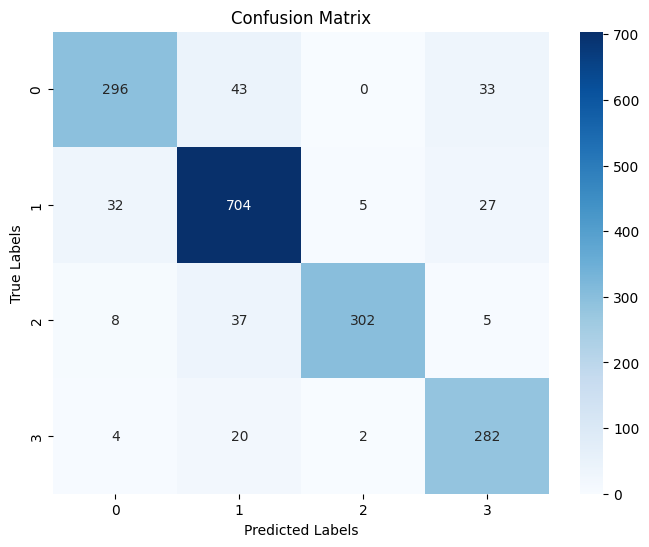

Epoch 1: Train Loss: 0.5108, Train Acc: 0.8092, Val Loss: 0.3494, Val Acc: 0.8800


Evaluating: 100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


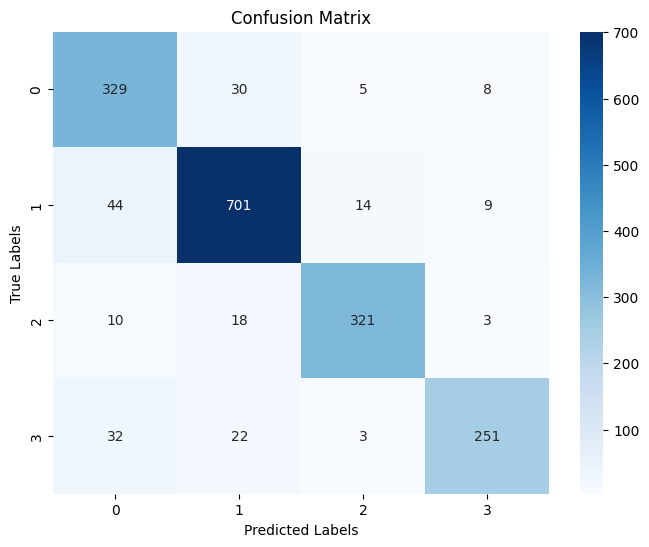

Epoch 2: Train Loss: 0.2639, Train Acc: 0.9116, Val Loss: 0.3389, Val Acc: 0.8900


Evaluating: 100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


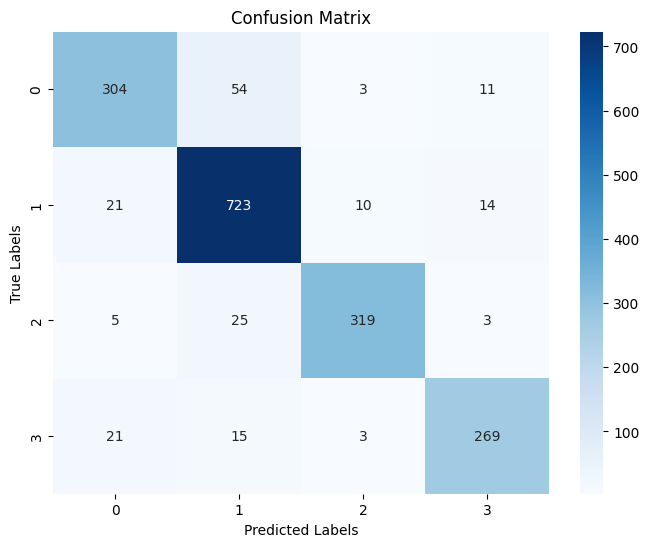

Epoch 3: Train Loss: 0.2069, Train Acc: 0.9316, Val Loss: 0.3355, Val Acc: 0.8972


Evaluating: 100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


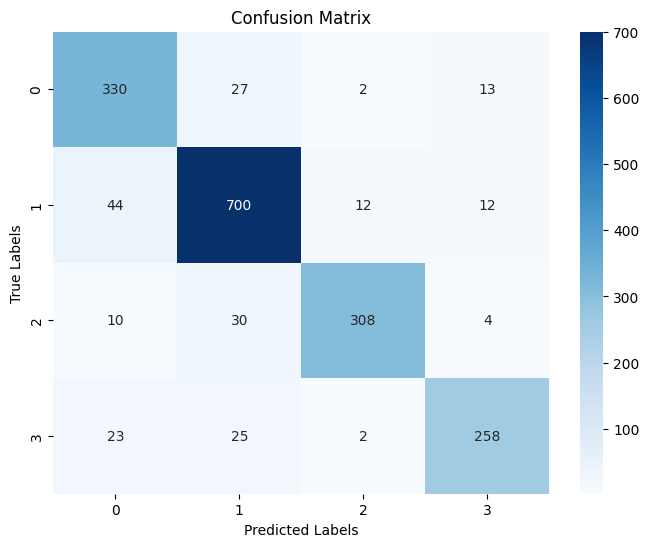

Epoch 4: Train Loss: 0.1735, Train Acc: 0.9396, Val Loss: 0.3558, Val Acc: 0.8867


Evaluating: 100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


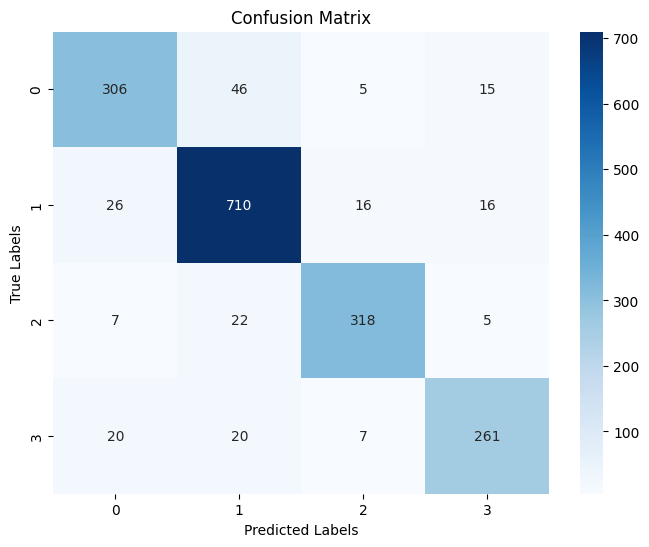

Epoch 5: Train Loss: 0.1317, Train Acc: 0.9558, Val Loss: 0.4132, Val Acc: 0.8861


Evaluating: 100%|██████████| 29/29 [01:22<00:00,  2.83s/it]


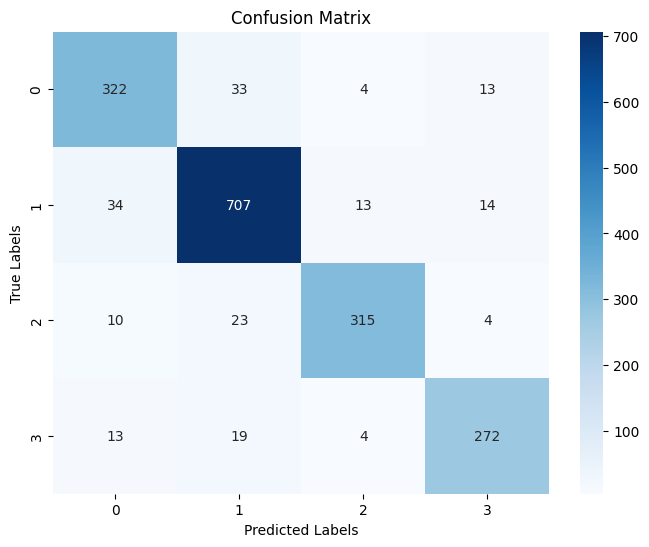

Epoch 6: Train Loss: 0.1153, Train Acc: 0.9600, Val Loss: 0.3972, Val Acc: 0.8978


Evaluating: 100%|██████████| 29/29 [01:27<00:00,  3.02s/it]


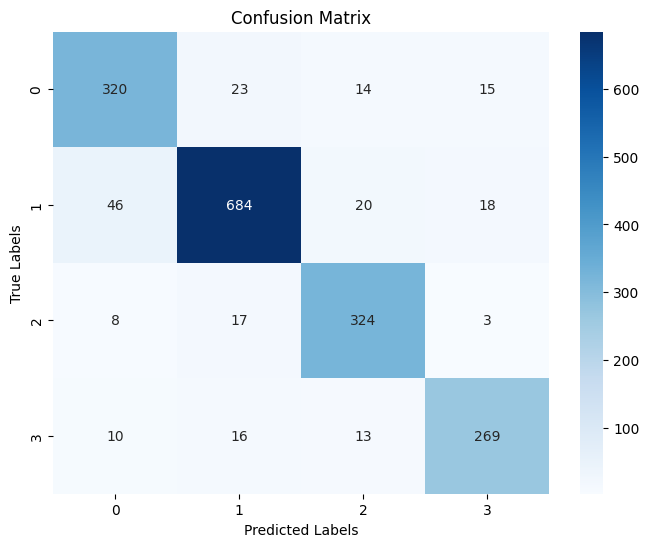

Epoch 7: Train Loss: 0.1050, Train Acc: 0.9623, Val Loss: 0.4002, Val Acc: 0.8872


Evaluating: 100%|██████████| 29/29 [01:25<00:00,  2.93s/it]


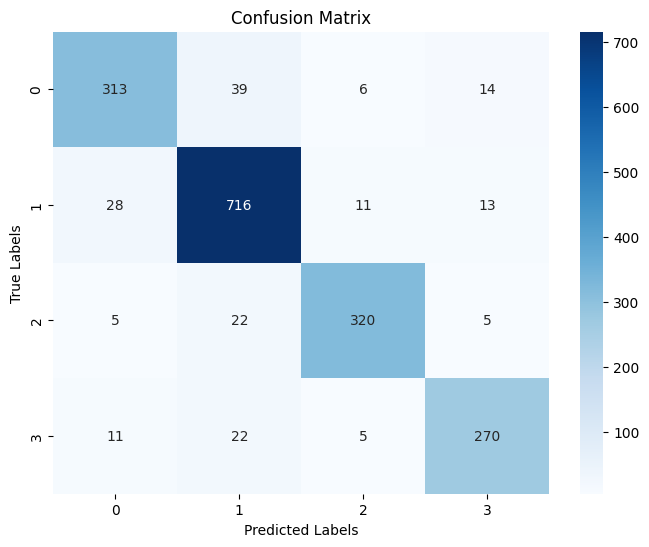

Epoch 8: Train Loss: 0.1057, Train Acc: 0.9628, Val Loss: 0.3379, Val Acc: 0.8994


Evaluating: 100%|██████████| 29/29 [01:27<00:00,  3.01s/it]


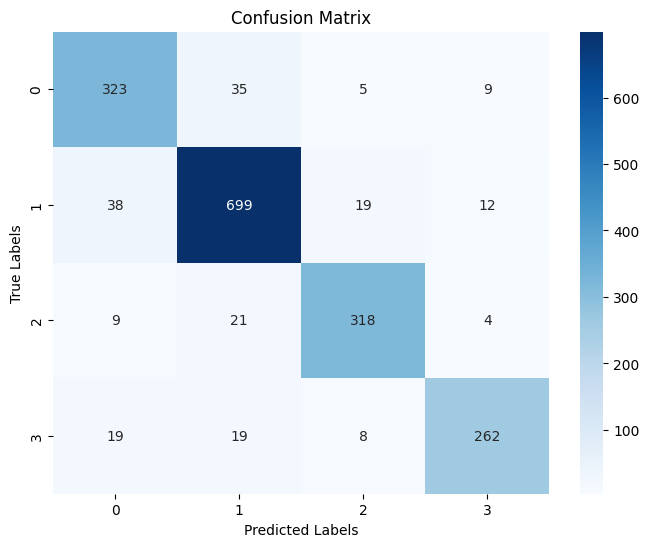

Epoch 9: Train Loss: 0.0815, Train Acc: 0.9720, Val Loss: 0.5300, Val Acc: 0.8900


Evaluating: 100%|██████████| 29/29 [01:22<00:00,  2.84s/it]


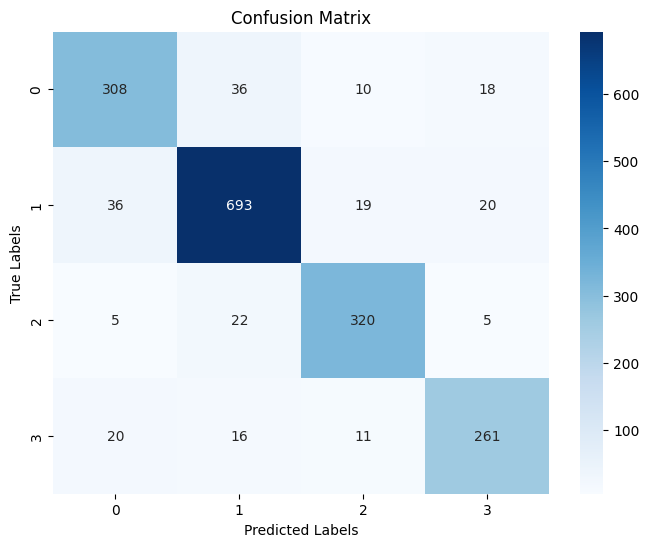

Epoch 10: Train Loss: 0.0774, Train Acc: 0.9747, Val Loss: 0.5003, Val Acc: 0.8789
Early stopping triggered.
Training complete!
Best model saved at ./garbage_net.pth


In [7]:
######################################## Training ########################################

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Initializing the tokenizer
model = GarbageClassification(num_classes=4).to(device) # Initializing the model
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001) # Initializing the optmizer
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True) # Initializing the scheduler
criterion = nn.CrossEntropyLoss() # Initializing the criterion (loss function)


def tokenize_batch(texts):
    # Tokenizer to encode the text inputs (padding and truncating automatically handled)
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Function to train the model for one epoch
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train() # Set the model to train mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, text_inputs, labels in tqdm(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Tokenize text inputs
        text_inputs = tokenize_batch(text_inputs)
        input_ids = text_inputs['input_ids'].to(device)
        attention_mask = text_inputs['attention_mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    return running_loss / len(data_loader), correct / total

# Define a function to evaluate the model on the validation set
def eval_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    total_predictions = []
    total_labels = []

    # No need to compute gradients for outputs during validation
    with torch.no_grad():
        for images, text_inputs, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            # Tokenize the text inputs and ensure correct access to 'input_ids' and 'attention_mask'
            text_inputs = tokenize_batch(text_inputs)
            input_ids = text_inputs['input_ids'].to(device)
            attention_mask = text_inputs['attention_mask'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Track accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # List of predictions and labels
            total_predictions.extend(predicted.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct / total

    cm = confusion_matrix(total_labels, total_predictions) # Create confusion matrix

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return epoch_loss, epoch_accuracy, cm

# Training loop
best_val_accuracy = 0.0
patience = 5
early_stop_count = 0

for epoch in range(nepochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, cm = eval_model(model, val_loader, criterion, device)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Saving the best model if the accuracy has improved or run early stopping
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), PATH_BEST)
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Early stopping triggered.")
            break

print("Training complete!")
print(f"Best model saved at {PATH_BEST}")

Testing the model using the test dataset

<ipython-input-8-e52ec974c1ba>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH_BEST))
Evaluating: 100%|██████████| 54/54 [19:34<00:00,

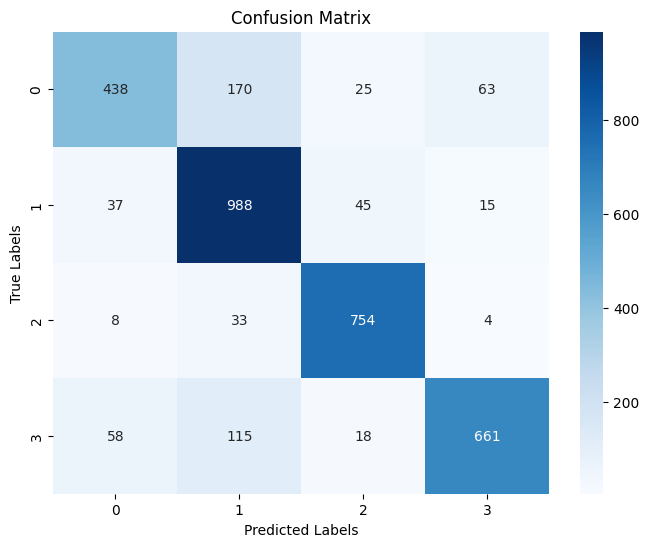

Test Loss: 0.6154
Test Accuracy: 82.78%


In [8]:
# Testing the best model using the test data
model.load_state_dict(torch.load(PATH_BEST))
test_loss, test_accuracy, cm = eval_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")